# TP2 - Jules Labrecques, Xavier Larouche et Marc-Antoine Samson

In [1]:
%pip install numpy matplotlib scipy

Note: you may need to restart the kernel to use updated packages.


### geo

In [2]:
### VARIABLES ###

### paramètres d'acquisition ###

## largeur d'un élément de détecteur (cm)
pixsize = 0.165

## taille du détecteur (nombre d'échantillons)
nbpix = 336

### paramètres de reconstruction ###

## taille de la grille d'image (carrée)
nbvox = 96 # options: 96, 192

## taille du voxel (carré) (cm)
voxsize = 0.4 # option: 0.4, 0.2

## fichiers d'entrée
dataDir = "./data/"
anglesFile = "angles.txt"
sinogramFile = "sinogram-password.txt"
sinogramFile = "sinogram-patient.txt"

### util

In [3]:
#libs
import scipy.interpolate
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import time

### fichier contenant les fonctions d'aide ###

## lire la liste des angles, convertir de degrés vers rad
## limiter à une plage [0, 2pi]
def readAngles(filename):

    angles = np.loadtxt(filename)
    nbprj = angles.shape[0]

    # convertir en radians element par element
    angles = (np.pi/180.0)*angles

    return [nbprj, angles]


## lire un sinogramme
def readSinogram(filename):
    
    sinogram = np.loadtxt(filename)
    nbprj = sinogram.shape[0]
    nbpix = sinogram.shape[1]

    return [nbprj, nbpix, sinogram]


#enregistrer l'image
def saveImage(image, prefix):
    im = plt.imshow(image, cmap = cm.Greys_r)
    plt.colorbar()
    plt.title("method: "+prefix)
    plt.savefig(prefix+"-"+time.strftime("%Y%m%d-%H%M%S")+".png")

### readInput

In [4]:
## créer l'ensemble de données d'entrée à partir des fichiers
def readInput():
    # lire les angles
    [nbprj, angles] = readAngles(dataDir+anglesFile)

    print("nbprj:",nbprj)
    print("angles min and max (rad):")
    print("["+str(np.min(angles))+", "+str(np.max(angles))+"]")

    # lire le sinogramme
    [nbprj2, nbpix2, sinogram] = readSinogram(dataDir+sinogramFile)

    if nbprj != nbprj2:
        print("angles file and sinogram file conflict, aborting!")
        exit(0)

    if nbpix != nbpix2:
        print("geo description and sinogram file conflict, aborting!")
        exit(0)

    return [nbprj, angles, sinogram]

## Quesiton 1

En assumant que le corps humain est fait d'eau pure, on trouve dans la base de données XCOM du NIST, que pour des photons de 60KeV, le coefficient d'atténuation massique est de 

$$\frac{\mu}{\rho} = 0.326 \ \ cm^2/g$$

Donc, avec une masse volumique de 1.0 g/cm3, on obtient 

$$\mu =  0.326 \ \ cm^{-1}$$

Pour trouver la fraction du signal qui subsiste, on sait premièrement que pour un matériau homogène comme l'eau, on a

$$I = I_0 \exp^{-\mu \Delta x}$$

$$\frac{I}{I_0} = \exp^{-\mu \Delta x}$$


Alors, après avoir traversé 5cm d'eau, on trouve :

$$\frac{I}{I_0} = \exp^{-0.326 \times 5} = 0.19593$$

Et pour 20cm d'eau :

$$\frac{I}{I_0} = \exp^{-0.326 \times 20} = 0.0014737$$

## Question 2

Fonction pour laminogramme de base, sans utilisation du slicing. Donc, fonction plus lente. 

nbprj: 720
angles min and max (rad):
[0.008726646259971648, 6.283185307179586]
working on image column: 1/96
working on image column: 2/96
working on image column: 3/96
working on image column: 4/96
working on image column: 5/96
working on image column: 6/96
working on image column: 7/96
working on image column: 8/96
working on image column: 9/96
working on image column: 10/96
working on image column: 11/96
working on image column: 12/96
working on image column: 13/96
working on image column: 14/96
working on image column: 15/96
working on image column: 16/96
working on image column: 17/96
working on image column: 18/96
working on image column: 19/96
working on image column: 20/96
working on image column: 21/96
working on image column: 22/96
working on image column: 23/96
working on image column: 24/96
working on image column: 25/96
working on image column: 26/96
working on image column: 27/96
working on image column: 28/96
working on image column: 29/96
working on image column: 30/96


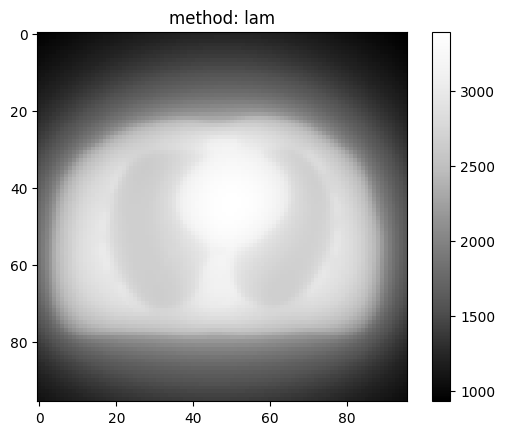

In [5]:
## reconstruire une image TDM en mode rétroprojection
def laminogram():
    
    [nbprj, angles, sinogram] = readInput()

    # initialiser une image reconstruite
    image = np.zeros((nbvox, nbvox))

    # Coordonnées du centre
    center_x = nbvox/2
    center_y = nbvox/2

    # "etaler" les projections sur l'image
    # ceci sera fait de façon "voxel-driven"
    # pour chaque voxel, trouver la contribution du signal reçu
    for j in range(nbvox): # colonnes de l'image, nbvox = taille du détecteur = 336
        print("working on image column: "+str(j+1)+"/"+str(nbvox))
        for i in range(nbvox): # lignes de l'image
            for a in range(len(angles)):
                # Pour chaque voxel, calcul des coordonnées cartésiennes par rapport au centre de l'image
                # Le centre de l'image est à l'origine.
                x = (center_x - j) * voxsize
                y = (i - center_y) * voxsize

                # Pour un angle donné, on projette le point (x,y) sur la droite du détecteur
                # t est la position relative sur le détecteur.
                t = x * np.cos(angles[a]) + y * np.sin(angles[a])

                # Convertir t en indice de pixel sur détecteur
                # C'est un float de la position exact où le rayon touche le détecteur
                detector_idx = nbpix/2 + t/pixsize

                # On doit donc interpoler pour obtenir la valeur du sinogramme à cet indice
                # Récupérer la valeur
                # Vérif si indice dans range du détecteur.
                if 0 <= detector_idx < nbpix:
                    # Interpolation linéaire
                    idx_floor = int(detector_idx)  # donne uniquement la partie entière (round down)
                    idx_ceil = min(idx_floor + 1, nbpix-1)  # donne le pixel suivant
                    weight = detector_idx - idx_floor
                    if 0 <= idx_floor < nbpix:
                        valeur_interpolee = (1-weight) * sinogram[a, idx_floor] + weight * sinogram[a, idx_ceil]

                        # Ajoute la valeur au voxel
                        image[i, j] += valeur_interpolee


    saveImage(image, "lam")
    

start_time = time.time()
laminogram()
print("--- %s seconds ---" % (time.time() - start_time))

Fonction de laminogramme optimisée avec sclicing numpy. 

nbprj: 720
angles min and max (rad):
[0.008726646259971648, 6.283185307179586]
Processing angle 1/720
Processing angle 2/720
Processing angle 3/720
Processing angle 4/720
Processing angle 5/720
Processing angle 6/720
Processing angle 7/720
Processing angle 8/720
Processing angle 9/720
Processing angle 10/720
Processing angle 11/720
Processing angle 12/720
Processing angle 13/720
Processing angle 14/720
Processing angle 15/720
Processing angle 16/720
Processing angle 17/720
Processing angle 18/720
Processing angle 19/720
Processing angle 20/720
Processing angle 21/720
Processing angle 22/720
Processing angle 23/720
Processing angle 24/720
Processing angle 25/720
Processing angle 26/720
Processing angle 27/720
Processing angle 28/720
Processing angle 29/720
Processing angle 30/720
Processing angle 31/720
Processing angle 32/720
Processing angle 33/720
Processing angle 34/720
Processing angle 35/720
Processing angle 36/720
Processing angle 37/720
Processing angle 38/720
Processing angle 3

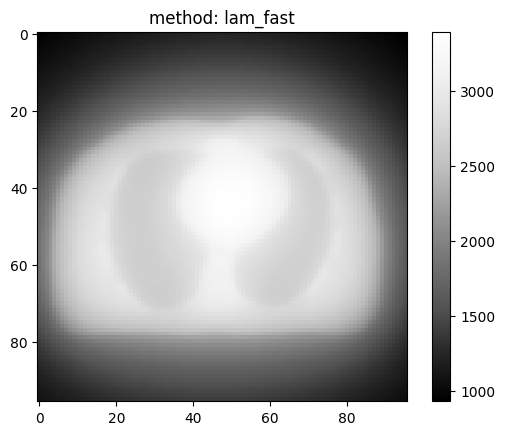

In [6]:
def laminogram_optimized():

    [nbprj, angles, sinogram] = readInput()

    # Initialiser une image reconstruite
    image = np.zeros((nbvox, nbvox))

    # Coordonnées du centre
    center_x = nbvox / 2
    center_y = nbvox / 2

    # Matrices 2D des coordonnées x et y de chaque voxel
    x_indices, y_indices = np.meshgrid(np.arange(nbvox), np.arange(nbvox))
    x_coords = (center_x - x_indices) * voxsize
    y_coords = (y_indices - center_y) * voxsize

    # Pour chaque angle
    for a in range(len(angles)):
        print(f"Processing angle {a + 1}/{len(angles)}")

        # Calculer la position sur le détecteur pour tous les voxels d'un coup
        t = x_coords * np.cos(angles[a]) + y_coords * np.sin(angles[a])

        # Convertir t en indices sur le détecteur
        detector_indices = nbpix/2 + t/pixsize

        # Créer un masque pour les indices valides
        valid_indices = (detector_indices >= 0) & (detector_indices < nbpix - 1)

        # Pour l'interpolation linéaire
        indices_floor = np.floor(detector_indices).astype(int)
        weights = detector_indices - indices_floor

        # Interpolation linéaire sur les indices valides
        valid_floor = np.clip(indices_floor[valid_indices], 0, nbpix - 2)
        valid_ceil = valid_floor + 1

        # Matrice temporaire pour les valeurs de cet angle
        temp_image = np.zeros_like(image)

        # Calculer les valeurs interpolées
        floor_values = sinogram[a, valid_floor]
        ceil_values = sinogram[a, valid_ceil]
        interpolated = (1 - weights[valid_indices]) * floor_values + weights[
            valid_indices] * ceil_values

        # Mettre valeurs aux indices
        temp_image[valid_indices] = interpolated

        # Ajouter à l'image
        image += temp_image

    saveImage(image, "lam_fast")
    

start_time = time.time()
laminogram_optimized()
print("--- %s seconds ---" % (time.time() - start_time))

La rétroprojection simple a créé une image floue. Chaque projection étale ses valeurs 
sur des lignes entières, ce qui crée des trainées dans l'image reconstruite.

## Question 3

In [7]:
import numpy as np

## filtrer le sinogramme
## ligne par ligne
def filterSinogram(sinogram):
    for i in range(sinogram.shape[0]):
        sinogram[i] = filterLine(sinogram[i])

## filter une ligne (projection) via FFT
def filterLine(projection):
    fft_proj = np.fft.fft(projection)

    # Taille du filtre
    n = len(projection)

    # Fréquences
    # fftshift pour avoir les fréquences dans l'ordre [-N/2, ..., -1, 0, 1, ..., N/2-1]
    freq = np.fft.fftshift(np.fft.fftfreq(n))

    # Filtre rampe
    ramp_filter = np.abs(freq)

    # Appliquer le filtre
    proj_shifted = np.fft.fftshift(fft_proj)
    filtered_proj = proj_shifted * ramp_filter

    # Inverser le shift
    filtered_proj = np.fft.ifftshift(filtered_proj)

    # Inverser la FFT
    filtered_proj = np.fft.ifft(filtered_proj)

    return np.real(filtered_proj)

Affichage et comparaison des deux sinogrammes : original et filtré.

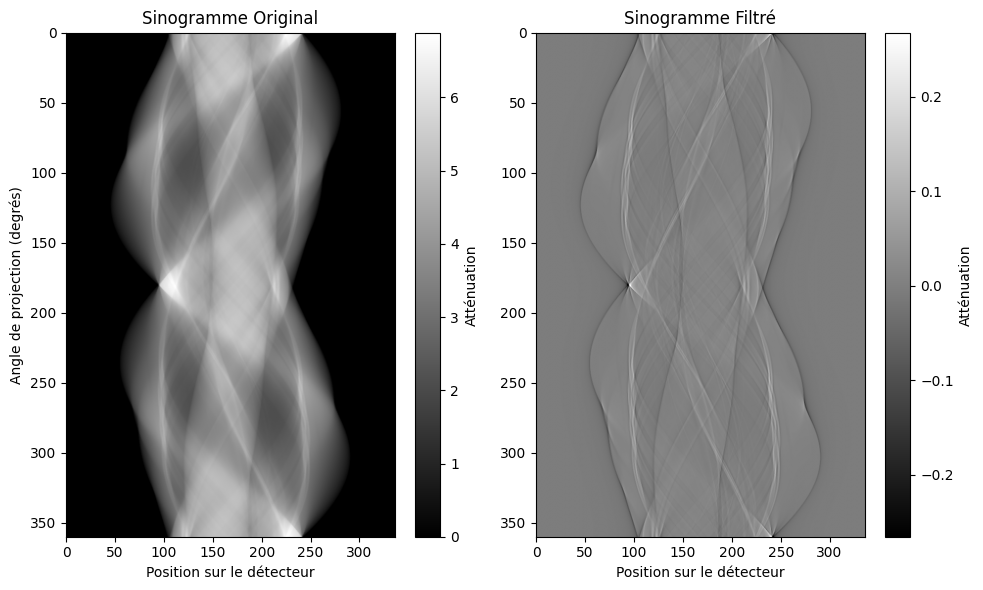

In [8]:
[nbprj, nbpix, sinogram_original] = readSinogram(dataDir + sinogramFile)
    
sinogram_filtered = np.copy(sinogram_original)

angles = np.linspace(0, 360, nbprj)

# Filtrer le sinogramme
filterSinogram(sinogram_filtered)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

# Original
im1 = ax1.imshow(sinogram_original, aspect='auto', cmap='gray', extent=[0, nbpix, angles[-1], angles[0]])
ax1.set_title('Sinogramme Original')
ax1.set_xlabel('Position sur le détecteur')
ax1.set_ylabel('Angle de projection (degrés)')

# Filtré
im2 = ax2.imshow(sinogram_filtered, aspect='auto', cmap='gray', extent=[0, nbpix, angles[-1], angles[0]])
ax2.set_title('Sinogramme Filtré')
ax2.set_xlabel('Position sur le détecteur')

plt.colorbar(im1, ax=ax1, label='Atténuation')
plt.colorbar(im2, ax=ax2, label='Atténuation')
plt.tight_layout()

# Sauvegarder l'image
plt.savefig("sinogram_comparison-" + time.strftime("%Y%m%d-%H%M%S") + ".png", dpi=300)

# Afficher la figure
plt.show()

### <span style="color:red"> Qualitativement, quelles sont les principales différences entre le sinogramme fourni et filtré? </span>

La différence est sur la résolution de l'information qui est présentée. dans le sinograme original, on voit que toute l'information est présentée sur un intervalle d'intensité plus grand, donc les couleurs sont plus variées. Du côté du sinogramme filtré, il y a seulement les détails fins qui sont rendus,
soit principalement les contours, représentés par des changements abruptes d’intensité. Ainsi, c'est une transformation de l'image où on a conservé les hautes fréquences en n'accordant peu d'importance aux basses fréquences, voir les annuler.

## Question 4

nbprj: 720
angles min and max (rad):
[0.008726646259971648, 6.283185307179586]
Processing angle 1/720
Processing angle 2/720
Processing angle 3/720
Processing angle 4/720
Processing angle 5/720
Processing angle 6/720
Processing angle 7/720
Processing angle 8/720
Processing angle 9/720
Processing angle 10/720
Processing angle 11/720
Processing angle 12/720
Processing angle 13/720
Processing angle 14/720
Processing angle 15/720
Processing angle 16/720
Processing angle 17/720
Processing angle 18/720
Processing angle 19/720
Processing angle 20/720
Processing angle 21/720
Processing angle 22/720
Processing angle 23/720
Processing angle 24/720
Processing angle 25/720
Processing angle 26/720
Processing angle 27/720
Processing angle 28/720
Processing angle 29/720
Processing angle 30/720
Processing angle 31/720
Processing angle 32/720
Processing angle 33/720
Processing angle 34/720
Processing angle 35/720
Processing angle 36/720
Processing angle 37/720
Processing angle 38/720
Processing angle 3

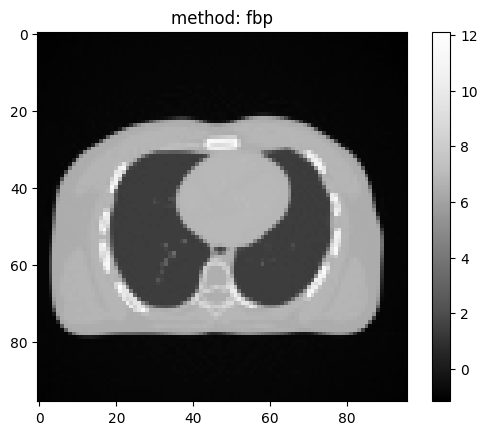

In [9]:
## reconstruire une image TDM en mode retroprojection filtrée
def backproject():
    
    [nbprj, angles, sinogram] = readInput()
    
    # initialiser une image reconstruite
    image = np.zeros((nbvox, nbvox))
    
    ### option filtrer ###
    filterSinogram(sinogram)
    ######

    # Coordonnées du centre
    center_x = nbvox / 2
    center_y = nbvox / 2

    # Matrices 2D des coordonnées x et y de chaque voxel
    x_indices, y_indices = np.meshgrid(np.arange(nbvox), np.arange(nbvox))
    x_coords = (center_x - x_indices) * voxsize
    y_coords = (y_indices - center_y) * voxsize

    # Pour chaque angle
    for a in range(len(angles)):
        print(f"Processing angle {a + 1}/{len(angles)}")

        # Calculer la position sur le détecteur pour tous les voxels d'un coup
        t = x_coords * np.cos(angles[a]) + y_coords * np.sin(angles[a])

        # Convertir t en indices sur le détecteur
        detector_indices = nbpix / 2 + t / pixsize

        # Créer un masque pour les indices valides
        valid_indices = (detector_indices >= 0) & (detector_indices < nbpix - 1)

        # Pour l'interpolation linéaire
        indices_floor = np.floor(detector_indices).astype(int)
        weights = detector_indices - indices_floor

        # Interpolation linéaire sur les indices valides
        valid_floor = np.clip(indices_floor[valid_indices], 0, nbpix - 2)
        valid_ceil = valid_floor + 1

        # Matrice temporaire pour les valeurs de cet angle
        temp_image = np.zeros_like(image)

        # Calculer les valeurs interpolées
        floor_values = sinogram[a, valid_floor]
        ceil_values = sinogram[a, valid_ceil]
        interpolated = (1 - weights[valid_indices]) * floor_values + weights[
            valid_indices] * ceil_values

        # Mettre valeurs aux indices
        temp_image[valid_indices] = interpolated

        # Ajouter à l'image
        image += temp_image
    
    saveImage(image, "fbp")
    

start_time = time.time()
backproject()
print("--- %s seconds ---" % (time.time() - start_time))

### <span style="color:red">Comparez l’image obtenue avec le fantôme. Quelles différences observez-vous ? Où sont situées les erreurs et que diriez-vous de la fréquence spatiale des erreurs? </span>

L’image est floue, donc on en comprend que nous avons perdu les changements rapides de contraste qui sont situés aux contours. Ces erreurs sont liées aux  fréquences élevées qui ont été partiellement annulées en conservant les fréquences plus basses. 

## Question 5

nbprj: 720
angles min and max (rad):
[0.008726646259971648, 6.283185307179586]


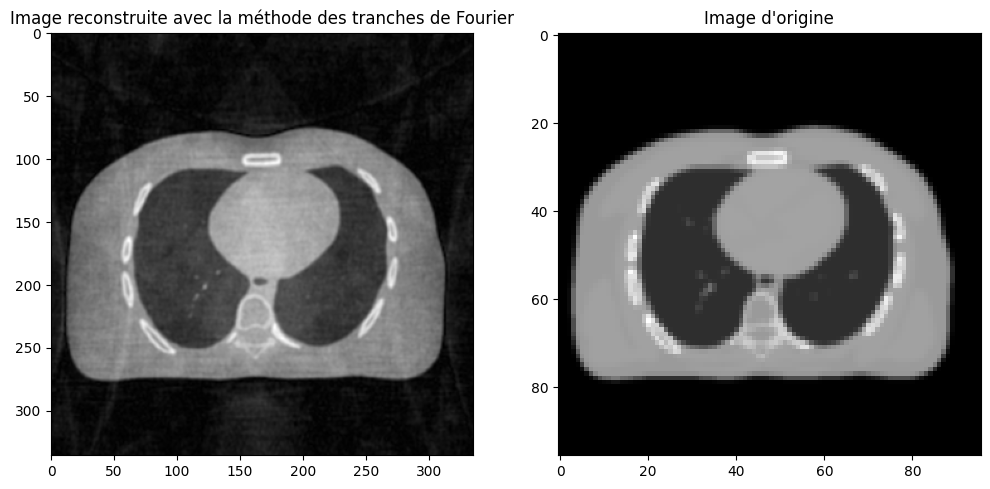

--- 2.371523380279541 seconds ---


In [10]:
def reconFourierSlice():
    [nbprj, angles, sinogram] = readInput()

    #On applique la transformée de Fourier à chaque ligne du sinogramme
    sinogram_fft_rows = np.fft.fftshift(np.fft.fft(np.fft.ifftshift(sinogram, axes=1)), axes=1)

    #On crée les coordonnées polaires
    r = np.arange(nbpix) - nbpix / 2
    r, angles = np.meshgrid(r, angles)
    r = r.ravel()
    angles = angles.ravel()

    #On crée les coordonnées cartésiennes et la grille de l'image pour interpoler les données
    x_array = (nbpix / 2) + r * np.cos(angles)
    y_array = (nbpix / 2) + r * np.sin(angles)
    x, y = np.meshgrid(np.arange(nbpix), np.arange(nbpix))

    #On interpole les données pour obtenir l'image en prennant seulement la partie réelle
    image_fft = scipy.interpolate.griddata((x_array, y_array), sinogram_fft_rows.ravel(), (x.ravel()[::-1], y.ravel()), method="nearest").reshape((nbpix, nbpix))
    image = np.abs(np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(image_fft))))

    # Zoom sur de l'image de manière à avoir le même zoom que l'image d'origine
    zoom_factor = 1.45
    image_center = np.array(image.shape) / 2
    zoomed_image = scipy.ndimage.zoom(image, zoom_factor)
    crop_x1 = int(image_center[0] * zoom_factor - image_center[0])
    crop_x2 = crop_x1 + image.shape[0]
    crop_y1 = int(image_center[1] * zoom_factor - image_center[1])
    crop_y2 = crop_y1 + image.shape[1]
    zoomed_image = zoomed_image[crop_x1:crop_x2, crop_y1:crop_y2]

    #On affiche l'image reconstruite et l'image d'origine
    z8ha9_image = plt.imread('Z8HA9.png')   
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].imshow(zoomed_image, cmap="gray")
    axs[0].set_title("Image reconstruite avec la méthode des tranches de Fourier")
    axs[1].imshow(z8ha9_image, cmap="gray")
    axs[1].set_title("Image d'origine")
    plt.show()

start_time = time.time()
reconFourierSlice()
print("--- %s seconds ---" % (time.time() - start_time))
